# AUTOMATIC KEYWORD EXTRACTOR - Training experiments
*Germán García García - gggsman@gmail.com*

_________________________________

MSC in Artificial Intelligence

Final Master´s project: Applying Deep Learning Techniques to Terminology Extraction in Specific Domains

Universidad Politecnica de Madrid


## Manual

**Description:**

The following Jupyter Notebook contains the cells of code needed to replicate the experiments presented in the document of the Final Master's Project, the main document can be found in the https://github.com/3Gsman/DeepTerminologyExtraction repository. It is an automatic keyword extractor system for training a model able to pick keywords from given texts. Acknowledgements to Sahrawat et ali.

**Abstract:**

Automatic terminology extraction or automatic keyphrase extraction is a very useful subfield of natural language processing when it comes to synthesizing information from texts in concise terms. In this master's thesis, this problem is approached with a sequence labeling approach using supervised deep learning techniques in specific domains, using bidirectional LTSM (Long short-term memory) neural networks and contextual word embeddings. A statistical significance study has been carried out to verify that the results presented in this work are significant. The final result in the F1 score in the Inspec dataset is 0.5730 slightly better than the higher result of the state of the art and it offers less dispersed results. Additionally, in this work the variation of samples in the training set is analyzed, a program to convert the datasets to a sequence labeling format needed for the final system is provided and there is an available sample program to test the keyphrase extractor in texts given by the user.

**Usage:**

To use this notebook you need to have a compatible dataset. Within this notebook, in the [github repository](https://github.com/3Gsman/DeepTerminologyExtraction) of this work, a folder named *datasets* is available, with all the datasets used during the experimentarion. Other option is to format your own dataset, in the same github repository can be found a script able to convert from 20 available keyword extraction datasets to the format needed in this notebook, please follow the instructions found in the folder *format_dataset*. The last option is to create or adapt your own dataset, the format needed is similar to CoNLL-03 but with only 3 tags: *B-KEY* for the word that begins the keyword, *I-KEY* for the subsequent words of the keyword, and *O* if that word it is not a keyword. If you have any question, plese contact with the author, Germán García in gggsman@gmail.com.

Once you have the dataset downloaded, upload it to google colab, in the left part of the interface a folder shaped button should be clicked, click and drag the dataset to the *Files* section and wait until is uploaded.

References:

D. Sahrawat, D. Mahata, H. Zhang, M. Kulkarni, A. Sharma, R. Gosangi, A.Stent, Y. Kumar, R. R. Shah y R. Zimmermann, “Keyphrase Extraction as Se-quence Labeling Using Contextualized Embeddings”

## Editable variables and hyperparameters:

In [ ]:
# Set download_model to True if you want to download the model at the end of the execution
download_model = False

# Set download_results to True if you want to download the results at the end of the execution
download_results = False

In [ ]:
# Edit the hyperparameters if you want to change the traning behaviour
class hyperparam:
  embedding = 'Bert'
  embedding_path = ''
  dataset_base_path = ''
  dataset = 'dataset'
  output_base_path = 'result/'
  iteration = ''
  gpu = 1
  lr = 0.05
  anneal_factor = 0.5
  patience = 4
  batch_size = 4
  num_epochs = 100
  threads = 12
  param_selection_mode = False
  use_tensorboard = False
  no_dev = False
  use_crf = True
  rnn_layers = 3
  hidden_size = 128
  dropout = 0.3
  word_dropout = 0.05
  locked_dropout = 0.5
  not_in_memory = False

## System startup

This section unzips the dataset and download the needed libraries to make this notebook work, also it imports the libraries

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/dev.txt         
  inflating: dataset/test.txt        
  inflating: dataset/train.txt       


In [ ]:
!pip install flair
!pip install pytorch_transformers

     |████████████████████████████████| 286kB 7.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 19.7MB 28.3MB/s 
     |████████████████████████████████| 1.2MB 39.2MB/s 
     |████████████████████████████████| 983kB 40.1MB/s 
     |████████████████████████████████| 798kB 39.8MB/s 
     |████████████████████████████████| 2.5MB 37.9MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 3.3MB 40.2MB/s 
     |████████████████████████████████| 901kB 56.9MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-cp37-none-any.whl size=9705 sha256=b38af4779fc6ac1e695ea59da6cfcceed2ea126970889ac8b4031ab0307bf2b2
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
  Created wheel for segtok: filena

In [ ]:
import sys
from typing import List
import argparse
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, FlairEmbeddings, CharacterEmbeddings, BertEmbeddings, TransformerXLEmbeddings, ELMoTransformerEmbeddings, ELMoEmbeddings,OpenAIGPTEmbeddings, RoBERTaEmbeddings,XLMEmbeddings, XLNetEmbeddings, OpenAIGPT2Embeddings
from flair.datasets import DataLoader
from flair.data import Corpus, Sentence
from flair.datasets import ColumnCorpus
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask
import flair.datasets
from flair.visual.training_curves import Plotter
from torch.utils.data import DataLoader
from flair.models import SequenceTagger
from google.colab import files
from flair.trainers import ModelTrainer
import torch.optim as optim
from pytorch_transformers import BertTokenizer
from flair.models import SequenceTagger
from pytorch_transformers import BertTokenizer

## Training

This section contains the functions and the call of the training function that gets the hyperparameters set above and trains a model.

In [ ]:
def bs(tokenizer,x,l,r,max_seq_len):
    if r>=l:
        mid = int(l + (r - l)/2)
        res=verifymid(tokenizer,x,mid,max_seq_len)
        if res==3:
            return mid
        elif res==2:
            return bs(tokenizer,x,mid+1,r,max_seq_len)
        else:
            return bs(tokenizer,x,l,mid-1,max_seq_len)
            
    else:
        print("wrong binary search")
        sys.exit()


def verifymid(tokenizer,x,mid,max_seq_len):
    limit=mid
    lw=x.to_tokenized_string().split(" ")
    lw=lw[:limit]
    sent=" ".join(lw)
    tokenized_text = tokenizer.tokenize(sent)
    if len(tokenized_text)>max_seq_len:
        return 1
    else:
        if verifymid_1(tokenizer,x,mid+1,max_seq_len)==True:
            return 2
        return 3
        
        
def verifymid_1(tokenizer,x,mid,max_seq_len):
    limit=mid
    lw=x.to_tokenized_string().split(" ")
    lw=lw[:limit]
    sent=" ".join(lw)
    tokenized_text = tokenizer.tokenize(sent)
    if len(tokenized_text)>max_seq_len:
        return False
    else:
        return True

In [ ]:
def train(data_path, list_embedding, output, hyperparameter ):

    # define columns
    columns = {0: 'text', 1: 'ner'}

    # retrieve corpus using column format, data folder and the names of the train, dev and test files
    if hyperparam.no_dev==True:
        corpus: Corpus = ColumnCorpus(data_path, 
                                      columns, 
                                      train_file='train.txt',
                                      test_file='test.txt',
                                      in_memory=not hyperparam.not_in_memory
                                     )
        
    else:
        corpus: Corpus = ColumnCorpus(data_path,
                                      columns,
                                      train_file='train.txt',
                                      test_file='test.txt',
                                      dev_file='dev.txt',
                                      in_memory=not hyperparam.not_in_memory
                                      )

    # 2. what tag do we want to predict?
    tag_type = 'ner'

    # 3. make the tag dictionary from the corpus
    tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
    print(tag_dictionary.idx2item)
    
    stats=corpus.obtain_statistics()
    print("Original\n",stats)
    
    # BERT Embeddings
    if hyperparam.embedding=="Bert":

        print("Tokenizer",hyperparam.embedding)
        if hyperparam.embedding_path!="":
            tokenizer = BertTokenizer.from_pretrained(hyperparam.embedding_path)
        else:
            tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        
        max_seq_len=500   
        print("taking max seq len as ",max_seq_len)        

        new_train=[]
        for x in corpus.train:

            tokenized_text = tokenizer.tokenize(x.to_plain_string())

            if len(tokenized_text)<=max_seq_len:
                new_train.append(x)
            
            else:          
                limit=bs(tokenizer,x,1,max_seq_len,max_seq_len)
                lw=x.to_tokenized_string().split(" ")
                lw=lw[:limit]
                sent=" ".join(lw)
                tokenized_text = tokenizer.tokenize(sent)
                
                if len(tokenized_text)>max_seq_len:
                    print("wrong binary search 1")
                    sys.exit()

                new_sent=Sentence(sent)
                for index in range(len(new_sent)):
                    try:
                        new_sent[index].add_tag('ner', x[index].get_tag('ner').value)
                    except:
                        pass

                new_train.append(new_sent)

        new_test=[]
        for x in corpus.test:

            tokenized_text = tokenizer.tokenize(x.to_plain_string())

            if len(tokenized_text)<=max_seq_len:
                new_test.append(x)
            
            else:           
                limit=bs(tokenizer,x,1,max_seq_len,max_seq_len)
                lw=x.to_tokenized_string().split(" ")
                lw=lw[:limit]
                sent=" ".join(lw)
                tokenized_text = tokenizer.tokenize(sent)

                if len(tokenized_text)>max_seq_len:
                    print("wrong binary search 1")
                    sys.exit()

                new_sent=Sentence(sent)
                for index in range(len(new_sent)):
                    try:
                        new_sent[index].add_tag('ner', x[index].get_tag('ner').value)
                    except:
                        pass

                new_test.append(new_sent)

        new_dev=[]
        for x in corpus.dev:

            tokenized_text = tokenizer.tokenize(x.to_plain_string())

            if len(tokenized_text)<=max_seq_len:
                new_dev.append(x)
            
            else:           
                limit=bs(tokenizer,x,1,max_seq_len,max_seq_len)
                lw=x.to_tokenized_string().split(" ")
                lw=lw[:limit]
                sent=" ".join(lw)
                tokenized_text = tokenizer.tokenize(sent)

                if len(tokenized_text)>max_seq_len:
                    print("wrong binary search 1")
                    sys.exit()

                new_sent=Sentence(sent)
                for index in range(len(new_sent)):
                    try:
                        new_sent[index].add_tag('ner', x[index].get_tag('ner').value)
                    except:
                        pass

                new_dev.append(new_sent)   

        corpus._train=new_train
        corpus._test=new_test
        corpus._dev=new_dev
        stats=corpus.obtain_statistics()
        print("Modified",stats)  

    # RoBERTa Embeddings
    elif hyperparam.embedding=="RoBERTa":

        print("Tokenizer",hyperparam.embedding)

        print("Using Bert tokenizer bert-base-uncased")
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        max_seq_len=500   
        print("taking max seq len as ",max_seq_len)
           
        new_train=[]
        for x in corpus.train:

            tokenized_text = tokenizer.tokenize(x.to_plain_string())

            if len(tokenized_text)<=max_seq_len:
                new_train.append(x)
            
            else:            
                limit=bs(tokenizer,x,1,max_seq_len,max_seq_len)
                lw=x.to_tokenized_string().split(" ")
                lw=lw[:limit]
                sent=" ".join(lw)
                tokenized_text = tokenizer.tokenize(sent)

                if len(tokenized_text)>max_seq_len:
                    print("wrong binary search 1")
                    sys.exit()

                new_sent=Sentence(sent)
                for index in range(len(new_sent)):
                    try:
                        new_sent[index].add_tag('ner', x[index].get_tag('ner').value)
                    except:
                        pass

                new_train.append(new_sent)

        new_test=[]
        for x in corpus.test:
            tokenized_text = tokenizer.tokenize(x.to_plain_string())
            if len(tokenized_text)<=max_seq_len:
                new_test.append(x)
            
            else:            
                limit=bs(tokenizer,x,1,max_seq_len,max_seq_len)
                lw=x.to_tokenized_string().split(" ")
                lw=lw[:limit]
                sent=" ".join(lw)
                tokenized_text = tokenizer.tokenize(sent)

                if len(tokenized_text)>max_seq_len:
                    print("wrong binary search 1")
                    sys.exit()

                new_sent=Sentence(sent)
                for index in range(len(new_sent)):
                    try:
                        new_sent[index].add_tag('ner', x[index].get_tag('ner').value)
                    except:
                        pass

                new_test.append(new_sent)

        new_dev=[]
        for x in corpus.dev:

            tokenized_text = tokenizer.tokenize(x.to_plain_string())
            
            if len(tokenized_text)<=max_seq_len:
                new_dev.append(x)
            
            else:            
                limit=bs(tokenizer,x,1,max_seq_len,max_seq_len)
                lw=x.to_tokenized_string().split(" ")
                lw=lw[:limit]
                sent=" ".join(lw)
                tokenized_text = tokenizer.tokenize(sent)

                if len(tokenized_text)>max_seq_len:
                    print("wrong binary search 1")
                    sys.exit()

                new_sent=Sentence(sent)
                for index in range(len(new_sent)):
                    new_sent[index].add_tag('ner', x[index].get_tag('ner').value)

                new_dev.append(new_sent)             
        
        corpus._train=new_train
        corpus._test=new_test
        corpus._dev=new_dev
        stats=corpus.obtain_statistics()
        print("Modified",stats)  


    # 4. initialize embeddings
    embedding_types: List[TokenEmbeddings] = list_embedding

    embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

    # 5. initialize sequence tagger

    tagger: SequenceTagger = SequenceTagger(hidden_size=hyperparam.hidden_size,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=hyperparam.use_crf,
                                        rnn_layers=hyperparam.rnn_layers,
                                        dropout=hyperparam.dropout, word_dropout=hyperparam.word_dropout, locked_dropout=hyperparam.locked_dropout
                                        )

    # 6. initialize trainer

    trainer: ModelTrainer = ModelTrainer(tagger, 
                                        corpus,
                                        use_tensorboard=hyperparam.use_tensorboard,
                                        optimizer=optim.SGD
                                        ) 

    # 7. start training
    trainer.train(output,
              learning_rate=hyperparam.lr,
              mini_batch_size=hyperparam.batch_size,
              anneal_factor=hyperparam.anneal_factor,
              patience=hyperparam.patience,
              max_epochs=hyperparam.num_epochs,
              param_selection_mode=hyperparam.param_selection_mode,
              num_workers=hyperparam.threads,
              
              )
    return trainer
    

In [ ]:
if hyperparam.embedding=='Bert':
    if hyperparam.embedding_path!="":
        embedding=BertEmbeddings(hyperparam.embedding_path)
    else:
        embedding=BertEmbeddings()

if hyperparam.embedding=='ELMo':
    if hyperparam.embedding_path!="":
        embedding=ELMoEmbeddings(hyperparam.embedding_path)
    else:
        embedding=ELMoEmbeddings()

if hyperparam.embedding=='RoBERTa':
    if hyperparam.embedding_path!="":
        embedding=RoBERTaEmbeddings(hyperparam.embedding_path)
    else:
        embedding=RoBERTaEmbeddings()

output=hyperparam.output_base_path+hyperparam.embedding+"_"+hyperparam.embedding_path +"_"+hyperparam.dataset+hyperparam.iteration+"_bs_"+str(hyperparam.batch_size)+ "_lr_"+str(hyperparam.lr)+ '_af_'+str(hyperparam.anneal_factor)+ '_p_'+ str(hyperparam.patience) +\
               "_hsize_"+str(hyperparam.hidden_size)+"_crf_"+str(int(hyperparam.use_crf))+"_lrnn_"+str(hyperparam.rnn_layers)+"_dp_"+str(hyperparam.dropout)+"_wdp_"+str(hyperparam.word_dropout)+"_ldp_"+str(hyperparam.locked_dropout)+"/"
dataset_path=hyperparam.dataset_base_path+hyperparam.dataset+"/"

print(output)
print(dataset_path)

print("\nHyper-Parameters\n")
arguments=vars(hyperparam)
for i in arguments:
    print('{0:25}  {1}'.format(i+":", str(arguments[i])))
    print(i+" : "+str(arguments[i]))

trainer=train(dataset_path,[embedding],output,hyperparam)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.
  """


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


result/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/
dataset/

Hyper-Parameters

__module__:                __main__
__module__ : __main__
embedding:                 Bert
embedding : Bert
embedding_path:            
embedding_path : 
dataset_base_path:         
dataset_base_path : 
dataset:                   dataset
dataset : dataset
output_base_path:          result/
output_base_path : result/
iteration:                 
iteration : 
gpu:                       1
gpu : 1
lr:                        0.05
lr : 0.05
anneal_factor:             0.5
anneal_factor : 0.5
patience:                  4
patience : 4
batch_size:                4
batch_size : 4
num_epochs:                3
num_epochs : 3
threads:                   12
threads : 12
param_selection_mode:      False
param_selection_mode : False
use_tensorboard:           False
use_tensorboard : False
no_dev:                    False
no_dev : False
use_crf:                   True
use_crf : True
rnn_

100%|██████████| 213450/213450 [00:00<00:00, 851307.56B/s]


taking max seq len as  500
Modified {
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 1000,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 141283,
            "min": 15,
            "max": 396,
            "avg": 141.283
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 500,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 67308,
            "min": 23,
            "max": 384,
            "avg": 134.616
        }
    },
    "DEV": {
        "dataset": "DEV",
        "total_number_of_documents": 500,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 66291,
            "min": 16,
            "max": 330,
            "avg": 132.582
        }
    }
}
2021-07-

## Results

In [ ]:
# save train and dev predictions
dev_DL = DataLoader(trainer.corpus.dev, batch_size=hyperparam.batch_size, num_workers=hyperparam.threads,)
dev_eval_result, dev_loss = trainer.model.evaluate(trainer.corpus.dev,out_path=output+"dev.tsv")

train_DL = DataLoader(trainer.corpus.train,batch_size=hyperparam.batch_size,num_workers=hyperparam.threads,)
train_eval_result, train_loss = trainer.model.evaluate(trainer.corpus.train,out_path=output+"train.tsv")

In [ ]:
# Print the results of the best model
print(dev_eval_result.detailed_results)
print(dev_loss)
print(train_eval_result.detailed_results)
print(train_loss)


Results:
- F1-score (micro) 0.5237
- F1-score (macro) 0.5237

By class:
KEY        tp: 2738 - fp: 3153 - fn: 1828 - precision: 0.4648 - recall: 0.5996 - f1-score: 0.5237
tensor(22.8412, device='cuda:0')

Results:
- F1-score (micro) 0.5295
- F1-score (macro) 0.5295

By class:
KEY        tp: 5928 - fp: 6686 - fn: 3850 - precision: 0.4700 - recall: 0.6063 - f1-score: 0.5295
tensor(24.5967, device='cuda:0')


2021-07-13 14:34:30,037 ----------------------------------------------------------------------------------------------------
2021-07-13 14:34:30,038 WARNING: No LOSS found for test split in this data.
2021-07-13 14:34:30,041 Are you sure you want to plot LOSS and not another value?
2021-07-13 14:34:30,042 ----------------------------------------------------------------------------------------------------
2021-07-13 14:34:30,070 ----------------------------------------------------------------------------------------------------
2021-07-13 14:34:30,071 WARNING: No F1 found for test split in this data.
2021-07-13 14:34:30,072 Are you sure you want to plot F1 and not another value?
2021-07-13 14:34:30,073 ----------------------------------------------------------------------------------------------------
Loss and F1 plots are saved in result/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/training.png


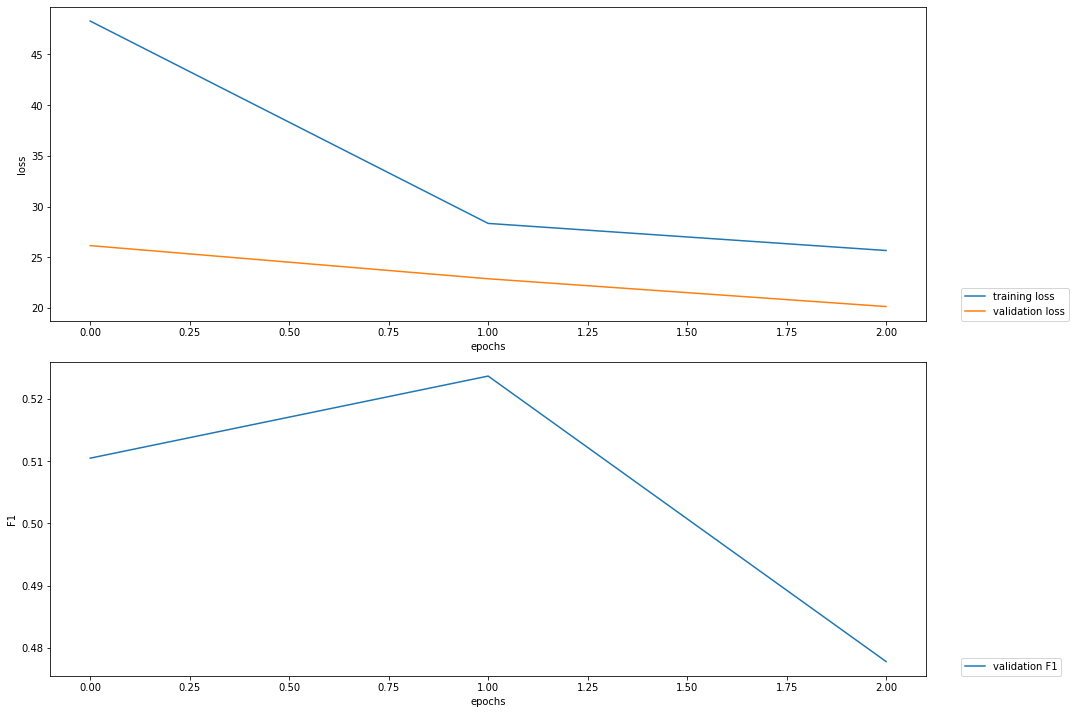

In [ ]:
# Plot the loss of the training and dev/validation set and F1 score evolution
plotter = Plotter()
plotter.plot_training_curves(output+'loss.tsv')

In [ ]:
# load the model and predcit the tags of a given sentence
model = SequenceTagger.load(output+'best-model.pt')
sentence = Sentence("Automatic terminology extraction or automatic keyphrase extraction is a very useful subfield of natural language processing when it comes to synthesizing information from texts in concise terms. In this master's thesis, this problem is approached with a sequence labeling approach using supervised deep learning techniques in specific domains, using bidirectional LTSM (Long short-term memory) neural networks and contextual word embeddings. A statistical significance study has been carried out to verify that the results presented in this work are significant. The final result in the F1 score in the Inspec dataset is 0.5730 slightly better than the higher result of the state of the art and it offers less dispersed results. Additionally, in this work the variation of samples in the training set is analyzed, a program to convert the datasets to a sequence labeling format needed for the final system is provided and there is an available sample program to test the keyphrase extractor in texts given by the user.")
model.predict(sentence)

print(sentence.to_tagged_string())

2021-07-13 14:34:32,119 loading file result/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/best-model.pt
Automatic <B-KEY> terminology <I-KEY> extraction <I-KEY> or automatic <B-KEY> keyphrase <I-KEY> extraction <I-KEY> is a very useful subfield of natural <B-KEY> language <I-KEY> processing <I-KEY> when it comes to synthesizing <B-KEY> information <I-KEY> from texts in concise terms . In this master 's thesis , this problem is approached with a sequence <B-KEY> labeling <I-KEY> approach <I-KEY> using supervised <B-KEY> deep <I-KEY> learning <I-KEY> techniques <I-KEY> in specific domains , using bidirectional <B-KEY> LTSM <I-KEY> ( Long <B-KEY> short-term <I-KEY> memory <I-KEY> ) neural <B-KEY> networks <I-KEY> and contextual <B-KEY> word <I-KEY> embeddings <I-KEY> . A statistical <B-KEY> significance <I-KEY> study <I-KEY> has been carried out to verify that the results presented in this work are significant . The final result in the F1 <B-KEY> sco

## Results download

In [ ]:
# If the variable download_model is True, Colab will download the model (aprox 500 mb)
if download_model:
  files.download(output+'best-model.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
if download_results:
  !cp -r /content/result /content/resultTemp
  !rm /content/resultTemp/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/final-model.pt
  !rm /content/resultTemp/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/best-model.pt
  !zip -r result.zip /content/resultTemp
  print("Commands executed")

  adding: content/resultTemp/ (stored 0%)
  adding: content/resultTemp/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/ (stored 0%)
  adding: content/resultTemp/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/training.png (deflated 25%)
  adding: content/resultTemp/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/loss.tsv (deflated 38%)
  adding: content/resultTemp/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/training.log (deflated 90%)
  adding: content/resultTemp/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/weights.txt (stored 0%)
  adding: content/resultTemp/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/dev.tsv (deflated 77%)
  adding: content/resultTemp/Bert__dataset_bs_4_lr_0.05_af_0.5_p_4_hsize_128_crf_1_lrnn_3_dp_0.3_wdp_0.05_ldp_0.5/test.tsv (deflated 7

In [ ]:
if download_results:
  files.download('result.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>